In [1]:
import os
import numpy as np
import pickle
import pandas as pd
from scipy.stats import zscore
from brainbox.io.one import SessionLoader
from sklearn.preprocessing import StandardScaler
import gc
import concurrent.futures

# from functions import get_speed, merge_licks, resample_common_time, interpolate_nans, fast_wavelet_morlet_convolution_parallel
# from functions import merge_licks, resample_common_time, interpolate_nans, low_pass, fast_wavelet_morlet_convolution_parallel
from functions import merge_licks, resample_common_time, interpolate_nans, low_pass
from one.api import ONE
one = ONE(mode='remote')


In [2]:

""" PARAMETERS """

# bin_size = 0.017  # np.round(1/60, 3)  # No binning, number indicates sampling rate
# first_90 = False  # Use full sessions #TODO consider removing this from here?

# # Wavelet decomposition
# f = np.array([.25, .5, 1, 2, 4, 8, 16])
# omega0 = 5

SAMPLING = {'left': 60,
            'right': 150,
            'body': 30}

In [3]:
""" Load BWM data post-QC """
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'
data_path = prefix + '/representation_learning_variability/paper-individuality/'
filename = '1_bwm_qc_07-10-2025'



data_path = prefix + 'representation_learning_variability/Video and wheel/Video QC/'
filename = 'final_lp_qc07-10-2025'


bwm_query = pickle.load(open(data_path+filename, "rb"))


In [4]:
# Loop through animals
sessions = bwm_query['eid'].unique()
data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/'
os.chdir(data_path)
files = os.listdir()
sessions_to_process = []

for s, sess in enumerate(sessions):
    file_path = one.eid2path(sess)

    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    filename = "design_matrix_" + str(sess) + '_'  + mouse_name
    if filename not in files:
        sessions_to_process.append((sess))

len(sessions_to_process)


218

In [9]:
def process_design_matrix(session):   

    file_path = one.eid2path(session)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_pose(views=['left', 'right'], tracker='lightningPose')
    sl.load_session_data(trials=True, wheel=True, motion_energy=True)

    # Check if all data is available
    if np.sum(sl.data_info['is_loaded']) >= 4:

        # Poses
        poses = sl.pose
        lc_t = np.asarray(poses['leftCamera']['times'])
        rc_t = np.asarray(poses['rightCamera']['times'])
        # Motion energy
        me = sl.motion_energy
        mel_t = lc_t
        mer_t = rc_t
        motion_energy_l = interpolate_nans(me['leftCamera']['whiskerMotionEnergy'], 'left')
        motion_energy_r = low_pass(interpolate_nans(me['rightCamera']['whiskerMotionEnergy'], 'right'), 
                                          cutoff=30, sf=SAMPLING['right'])
        # Licks
        features = ['tongue_end_l_x', 'tongue_end_l_y', 'tongue_end_r_x', 'tongue_end_r_y']
        lick_t, licks = merge_licks(poses, features, common_fs=150)
        # Paws
        l_paw_x = interpolate_nans(poses['leftCamera']['paw_r_x'], 'left')
        l_paw_y = interpolate_nans(poses['leftCamera']['paw_r_y'], 'left')
        r_paw_x = low_pass(interpolate_nans(poses['rightCamera']['paw_r_x'], 'right'), 
                                          cutoff=30, sf=SAMPLING['right'])
        r_paw_y = low_pass(interpolate_nans(poses['rightCamera']['paw_r_y'], 'right'), 
                                          cutoff=30, sf=SAMPLING['right'])
        l_paw_t = lc_t
        r_paw_t = rc_t
        # Wheel
        wheel = sl.wheel
        wheel_t = np.asarray(wheel['times'], dtype=np.float64)
        wheel_vel = wheel['velocity'].astype(np.float32)

        # Common resampling window
        onset = max(lc_t.min(), rc_t.min(), wheel_t.min(), lick_t.min())
        offset = min(lc_t.max(), rc_t.max(), wheel_t.max(), lick_t.max())
        fs = 60
        ref_t = np.arange(onset, offset, 1 / fs, dtype=np.float64)

        # Restrict to time window
        def restrict(t, x):
            mask = (t >= onset) & (t <= offset)
            return t[mask], x[mask]

        mel_t, motion_energy_l = restrict(mel_t, motion_energy_l)
        mer_t, motion_energy_r = restrict(mer_t, motion_energy_r)
        wheel_t, wheel_vel = restrict(wheel_t, wheel_vel)
        l_paw_t_x, l_paw_x = restrict(l_paw_t, l_paw_x)
        l_paw_t_y, l_paw_y = restrict(l_paw_t, l_paw_y)
        r_paw_t_x, r_paw_x = restrict(r_paw_t, r_paw_x)
        r_paw_t_y, r_paw_y = restrict(r_paw_t, r_paw_y)
        lick_t, licks = restrict(lick_t, licks)

        # Resample
        mel_down, rt = resample_common_time(ref_t, mel_t, motion_energy_l, kind='linear')
        mer_down, _ = resample_common_time(ref_t, mer_t, motion_energy_r, kind='linear')
        wh_down, _ = resample_common_time(ref_t, wheel_t, wheel_vel, kind='linear')
        lk_down, _ = resample_common_time(ref_t, lick_t, licks, kind='nearest')
        lpx_down, _ = resample_common_time(ref_t, l_paw_t_x, l_paw_x, kind='linear')
        lpy_down, _ = resample_common_time(ref_t, l_paw_t_y, l_paw_y, kind='linear')
        rpx_down, _ = resample_common_time(ref_t, r_paw_t_x, r_paw_x, kind='linear')
        rpy_down, _ = resample_common_time(ref_t, r_paw_t_y, r_paw_y, kind='linear')

        # Create design matrix
        design_matrix = pd.DataFrame({
            'Bin': rt,
            'Lick count': lk_down.astype(np.int8),
            'avg_wheel_vel': wh_down,
            'whisker_me': mel_down,  # zscore(mel_down, nan_policy='omit'),
            'avg_whisker_me': np.nanmean([mel_down, mer_down], axis=0),  # zscore(np.nanmean([mel_down, mer_down], axis=0), nan_policy='omit'),
            'l_paw_x': lpx_down,
            'l_paw_y': lpy_down,
            'r_paw_x': rpx_down,
            'r_paw_y': rpy_down,
        })

        # """ LOAD TRIAL DATA """
        session_trials = sl.trials
        session_start = list(session_trials['goCueTrigger_times'])[0]
        design_matrix = design_matrix.loc[(design_matrix['Bin'] > session_start)]

        """ SAVE DATA """       
        # Save unnormalized design matrix
        data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/'
        filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
        design_matrix.to_parquet(filename, compression='gzip')  

        # Save trials
        data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/'
        filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
        session_trials.to_parquet(filename, compression='gzip')  
        
        del design_matrix, session_trials, sl
        gc.collect()

    else:
        print('Data missing for session '+session)  


def parallel_process_data(sessions, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        # Process each chunk in parallel
        executor.map(function_name, sessions)

In [10]:
for s, session in enumerate(sessions_to_process):
    process_design_matrix(session)

2025-09-09 12:45:36 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:45:37 INFO     one.py:1288 Loading wheel data
2025-09-09 12:45:38 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:45:39 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-04", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-30/2020-10-20/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 359M/359M [00:25<00:00, 14.0MB/s] 


2025-09-09 12:46:14 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:46:15 INFO     one.py:1288 Loading wheel data
2025-09-09 12:46:16 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:46:17 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:46:17 WARNING  one.py:1292 Could not load pupil data.


(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-30/2020-10-21/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 359M/359M [00:24<00:00, 14.4MB/s] 


2025-09-09 12:46:50 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:46:51 INFO     one.py:1288 Loading wheel data
2025-09-09 12:46:52 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:46:53 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:46:53 WARNING  one.py:1292 Could not load pupil data.


(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-30/2020-10-22/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 415M/415M [00:26<00:00, 15.4MB/s] 


2025-09-09 12:47:29 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:47:30 INFO     one.py:1288 Loading wheel data
2025-09-09 12:47:31 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-02"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:47:32 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:47:32 WARNING  one.py:1292 Could not load pupil data.


local file size mismatch on dataset: angelakilab/Subjects/NYU-39/2021-05-10/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-39/2021-05-10/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 113M/113M [00:08<00:00, 12.7MB/s] 


2025-09-09 12:47:51 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:47:52 INFO     one.py:1288 Loading wheel data
2025-09-09 12:47:53 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:47:53 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:47:54 WARNING  one.py:1292 Could not load pupil data.


local file size mismatch on dataset: angelakilab/Subjects/NYU-39/2021-05-11/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-39/2021-05-11/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 114M/114M [00:10<00:00, 10.7MB/s] 


2025-09-09 12:48:12 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:48:13 INFO     one.py:1288 Loading wheel data
2025-09-09 12:48:14 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:48:15 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:48:15 WARNING  one.py:1292 Could not load pupil data.


local file size mismatch on dataset: angelakilab/Subjects/NYU-39/2021-05-12/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-39/2021-05-12/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 116M/116M [00:11<00:00, 10.3MB/s] 


2025-09-09 12:48:34 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:48:35 INFO     one.py:1288 Loading wheel data
2025-09-09 12:48:36 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:48:37 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:48:37 WARNING  one.py:1292 Could not load pupil data.


local file size mismatch on dataset: angelakilab/Subjects/NYU-39/2021-05-13/002/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-39/2021-05-13/002/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 130M/130M [00:08<00:00, 15.4MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-39/2021-05-13/002/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 295M/295M [00:23<00:00, 12.7MB/s] 


2025-09-09 12:49:16 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:49:17 INFO     one.py:1288 Loading wheel data
2025-09-09 12:49:18 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:49:19 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:49:20 WARNING  one.py:1292 Could not load pupil data.


local file size mismatch on dataset: angelakilab/Subjects/NYU-39/2021-05-14/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-39/2021-05-14/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 123M/123M [00:12<00:00, 9.98MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-39/2021-05-14/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 278M/278M [00:20<00:00, 13.4MB/s] 


2025-09-09 12:50:01 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:50:02 INFO     one.py:1288 Loading wheel data
2025-09-09 12:50:03 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:50:04 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:50:04 WARNING  one.py:1292 Could not load pupil data.


local file size mismatch on dataset: angelakilab/Subjects/NYU-40/2021-04-13/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-13/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 116M/116M [00:08<00:00, 13.5MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-13/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 266M/266M [00:23<00:00, 11.6MB/s] 


2025-09-09 12:50:43 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:50:44 INFO     one.py:1288 Loading wheel data
2025-09-09 12:50:45 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:50:46 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
local file size mismatch on dataset: angelakilab/Subjects/NYU-40/2021-04-14/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-14/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 123M/123M [00:08<00:00, 14.6MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-14/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 282M/282M [00:20<00:00, 13.7MB/s] 


2025-09-09 12:51:23 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:51:24 INFO     one.py:1288 Loading wheel data
2025-09-09 12:51:25 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:51:26 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:51:26 WARNING  one.py:1292 Could not load pupil data.


local file size mismatch on dataset: angelakilab/Subjects/NYU-40/2021-04-15/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-15/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 118M/118M [00:09<00:00, 12.5MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-15/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 268M/268M [00:22<00:00, 11.8MB/s] 


2025-09-09 12:52:06 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:52:07 INFO     one.py:1288 Loading wheel data
2025-09-09 12:52:08 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:52:09 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:52:09 WARNING  one.py:1292 Could not load pupil data.


local file size mismatch on dataset: angelakilab/Subjects/NYU-40/2021-04-16/002/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-16/002/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 110M/110M [00:12<00:00, 8.48MB/s] 


2025-09-09 12:52:29 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:52:30 INFO     one.py:1288 Loading wheel data
2025-09-09 12:52:31 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:52:32 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:52:32 WARNING  one.py:1292 Could not load pupil data.


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-05-29", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-45/2021-07-19/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 270M/270M [00:23<00:00, 11.6MB/s] 


2025-09-09 12:53:03 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:53:04 INFO     one.py:1288 Loading wheel data
2025-09-09 12:53:05 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:53:06 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
local file size mismatch on dataset: angelakilab/Subjects/NYU-45/2021-07-20/002/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-45/2021-07-20/002/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 120M/120M [00:11<00:00, 10.8MB/s] 


2025-09-09 12:53:25 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:53:26 INFO     one.py:1288 Loading wheel data
2025-09-09 12:53:27 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:53:28 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
local file size mismatch on dataset: angelakilab/Subjects/NYU-45/2021-07-23/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-45/2021-07-23/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 133M/133M [00:10<00:00, 13.2MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-45/2021-07-23/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 305M/305M [00:24<00:00, 12.3MB/s] 


2025-09-09 12:54:10 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:54:11 INFO     one.py:1288 Loading wheel data
2025-09-09 12:54:12 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:54:13 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
local file size mismatch on dataset: angelakilab/Subjects/NYU-46/2021-06-22/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-22/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 132M/132M [00:10<00:00, 12.2MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-22/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 302M/302M [00:18<00:00, 16.1MB/s] 


2025-09-09 12:54:50 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:54:51 INFO     one.py:1288 Loading wheel data
2025-09-09 12:54:52 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:54:53 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:54:53 WARNING  one.py:1292 Could not load pupil data.


local file size mismatch on dataset: angelakilab/Subjects/NYU-46/2021-06-23/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-23/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 138M/138M [00:12<00:00, 10.7MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-23/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 318M/318M [00:23<00:00, 13.8MB/s] 


2025-09-09 12:55:37 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:55:38 INFO     one.py:1288 Loading wheel data
2025-09-09 12:55:39 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:55:40 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
local file size mismatch on dataset: angelakilab/Subjects/NYU-46/2021-06-24/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-24/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 132M/132M [00:09<00:00, 14.6MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-24/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 302M/302M [00:32<00:00, 9.44MB/s] 


2025-09-09 12:56:29 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:56:30 INFO     one.py:1288 Loading wheel data
2025-09-09 12:56:31 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:56:32 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
local file size mismatch on dataset: angelakilab/Subjects/NYU-46/2021-06-25/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-25/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 121M/121M [00:12<00:00, 9.96MB/s] 


2025-09-09 12:56:52 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:56:53 INFO     one.py:1288 Loading wheel data
2025-09-09 12:56:54 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:56:55 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
local file size mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-22/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-22/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 133M/133M [00:09<00:00, 13.6MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-22/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 307M/307M [00:21<00:00, 14.0MB/s] 


2025-09-09 12:57:35 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:57:36 INFO     one.py:1288 Loading wheel data
2025-09-09 12:57:37 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:57:38 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:57:38 WARNING  one.py:1292 Could not load pupil data.


local file size mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 128M/128M [00:12<00:00, 10.2MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 295M/295M [00:39<00:00, 7.50MB/s] 


2025-09-09 12:58:38 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:58:39 INFO     one.py:1288 Loading wheel data
2025-09-09 12:58:39 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:58:40 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
local file size mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-25/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-25/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 141M/141M [00:09<00:00, 14.1MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-25/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 329M/329M [00:25<00:00, 13.1MB/s] 


2025-09-09 12:59:24 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:59:24 INFO     one.py:1288 Loading wheel data
2025-09-09 12:59:26 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:59:27 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 12:59:27 WARNING  one.py:1292 Could not load pupil data.


(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-48/2021-06-29/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 294M/294M [00:31<00:00, 9.46MB/s] 


2025-09-09 13:00:06 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 13:00:07 INFO     one.py:1288 Loading wheel data
2025-09-09 13:00:08 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 13:00:09 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-04", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
local file size mismatch on dataset: angelakilab/Subjects/NYU-48/2021-07-01/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-48/2021-07-01/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 122M/122M [00:10<00:00, 11.2MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-48/2021-07-01/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 281M/281M [00:23<00:00, 12.1MB/s] 


2025-09-09 13:00:51 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 13:00:52 INFO     one.py:1288 Loading wheel data
2025-09-09 13:00:53 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 13:00:54 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
local file size mismatch on dataset: angelakilab/Subjects/NYU-48/2021-07-02/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-48/2021-07-02/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 143M/143M [00:09<00:00, 14.7MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-48/2021-07-02/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 334M/334M [00:27<00:00, 12.1MB/s] 


2025-09-09 13:01:42 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 13:01:43 INFO     one.py:1288 Loading wheel data
2025-09-09 13:01:44 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 13:01:45 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-65/2022-09-12/002/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 350M/350M [00:36<00:00, 9.68MB/s] 


2025-09-09 13:02:30 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 13:02:31 INFO     one.py:1288 Loading wheel data
2025-09-09 13:02:32 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-06-02"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-09-09 13:02:33 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-04", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
local file size mismatch on dataset: angelakilab/Subjects/NYU-65/2022-09-15/001/alf/_ibl_leftCamera.lightningPose.pqt
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-65/2022-09-15/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 207M/207M [00:20<00:00, 10.1MB/s] 
(S3) /Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-65/2022-09-15/001/alf/_ibl_rightCamera.lightningPose.pqt:  84%|████████▎ | 417M/498M [00:28<00:05, 14.8MB/s] 


KeyboardInterrupt: 

(0.0, 20.0)

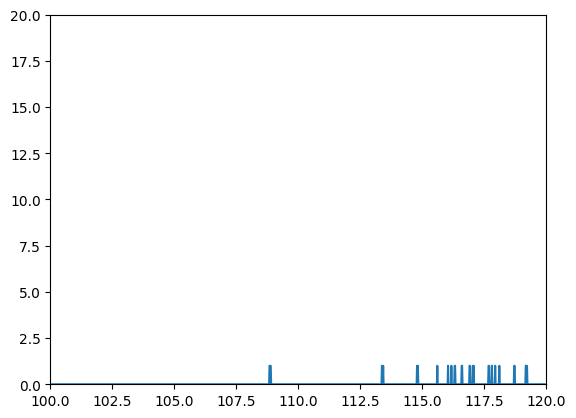

In [87]:
plt.plot(rt, lk_down)
plt.xlim([100, 120])
plt.ylim([0, 20])

(0.0, 15.0)

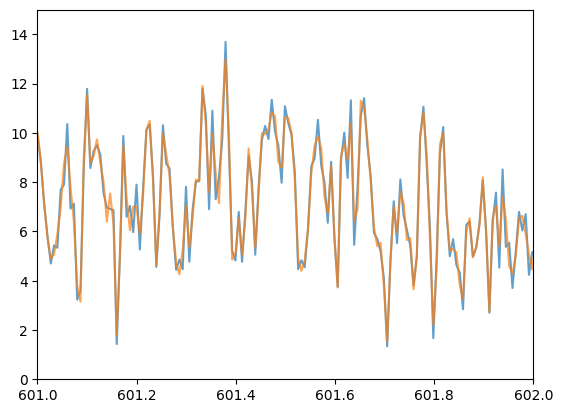

In [79]:
plt.plot(me['rightCamera']['times'], interp_pose,alpha=.7)
plt.plot(me['rightCamera']['times'], smoothed, alpha=.7)

plt.xlim([601, 602])
plt.ylim([0, 15])
# plt.ylim([200, 600])

(0.0, 15.0)

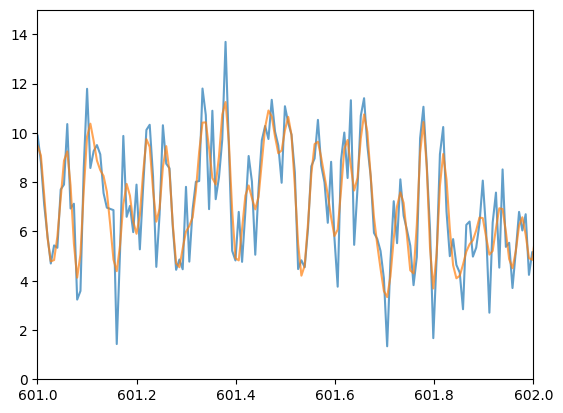

In [81]:
plt.plot(me['rightCamera']['times'], interp_pose,alpha=.7)
plt.plot(me['rightCamera']['times'], smoothed, alpha=.7)

plt.xlim([601, 602])
plt.ylim([0, 15])
# plt.ylim([200, 600])

(300.0, 310.0)

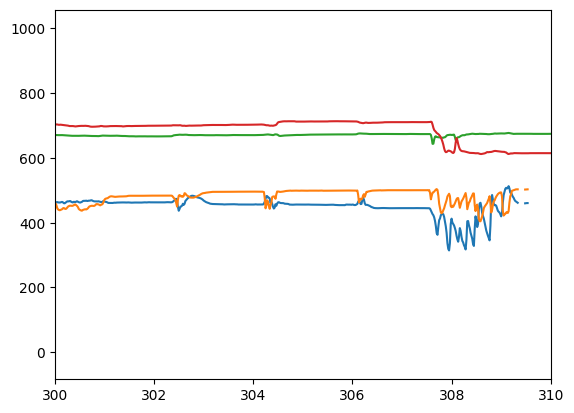

In [19]:
import matplotlib.pyplot as plt

plt.plot(df.Bin, df.r_paw_x)
plt.plot(df.Bin, df.r_paw_y)
plt.plot(df.Bin, df.l_paw_x)
plt.plot(df.Bin, df.l_paw_y)
plt.xlim([300, 310])

(-1.5, 10.0)

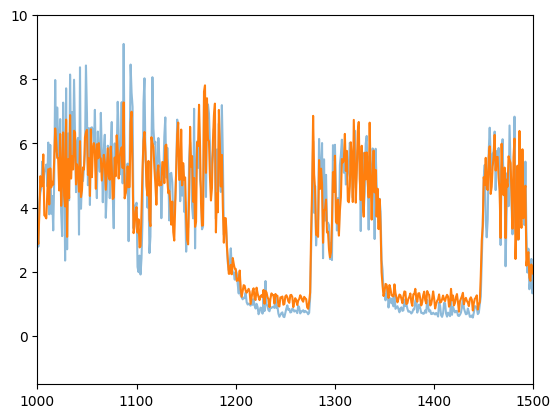

In [131]:
import matplotlib.pyplot as plt
# plt.plot(mer_down, alpha=0.5)
# plt.plot(mer_down, alpha=0.5)
plt.plot(mel_down, alpha=0.5)
plt.plot(np.nanmean([mel_down, mer_down], axis=0))
# plt.plot(zscore(np.nanmean([mel_down, mer_down], axis=0), nan_policy='omit'))

init=1000
plt.xlim([init, init+500])
plt.ylim([-1.5, 10])

(2000.0, 3000.0)

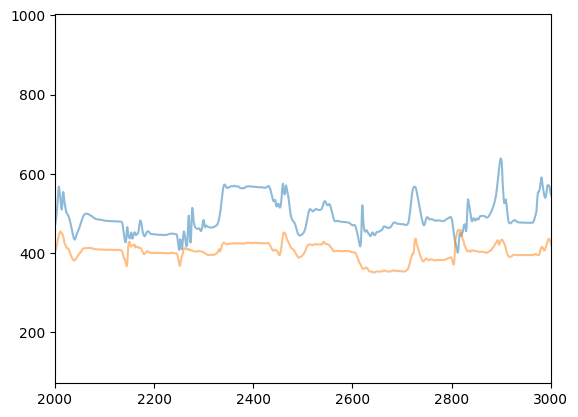

In [136]:
import matplotlib.pyplot as plt
# plt.plot(mer_down, alpha=0.5)
plt.plot(lpx_down, alpha=0.5)
plt.plot(rpx_down, alpha=0.5)
init=2000
plt.xlim([init, init+1000])
# plt.ylim([-1.5, 5])

In [ ]:
def process_design_matrix(session):    

    file_path = one.eid2path(session)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_pose(views=['left', 'right'], tracker='lightningPose')
    sl.load_session_data(trials=True, wheel=True, motion_energy=True)

    # Check if all data is available
    if np.sum(sl.data_info['is_loaded']) >= 4:

        # Poses
        poses = sl.pose
        lc_t = np.asarray(poses['leftCamera']['times'])
        rc_t = np.asarray(poses['rightCamera']['times'])
        # Motion energy
        me = sl.motion_energy
        mel_t = lc_t
        mer_t = rc_t
        motion_energy_l = zscore(me['leftCamera']['whiskerMotionEnergy'], nan_policy='omit').astype(np.float32)
        motion_energy_r = zscore(me['rightCamera']['whiskerMotionEnergy'], nan_policy='omit').astype(np.float32)
        # Licks
        features = ['tongue_end_l_x', 'tongue_end_l_y', 'tongue_end_r_x', 'tongue_end_r_y']
        lick_t, licks = merge_licks(poses, features, common_fs=150)
        # Paws
        l_paw_x = interpolate_nans(poses['leftCamera']['paw_r_x'], 'left')
        l_paw_y = interpolate_nans(poses['leftCamera']['paw_r_y'], 'left')
        r_paw_x = interpolate_nans(poses['rightCamera']['paw_r_x'], 'right')
        r_paw_y = interpolate_nans(poses['rightCamera']['paw_r_y'], 'right')
        l_paw_t = lc_t
        r_paw_t = rc_t
        # Wheel
        wheel = sl.wheel
        wheel_t = np.asarray(wheel['times'], dtype=np.float64)
        wheel_vel = wheel['velocity'].astype(np.float32)

        # Common resampling window
        onset = max(lc_t.min(), rc_t.min(), wheel_t.min(), lick_t.min())
        offset = min(lc_t.max(), rc_t.max(), wheel_t.max(), lick_t.max())
        fs = 60
        ref_t = np.arange(onset, offset, 1 / fs, dtype=np.float64)

        # Restrict to time window
        def restrict(t, x):
            mask = (t >= onset) & (t <= offset)
            return t[mask], x[mask]

        lc_t, motion_energy_l = restrict(mel_t, motion_energy_l)
        rc_t, motion_energy_r = restrict(mer_t, motion_energy_r)
        wheel_t, wheel_vel = restrict(wheel_t, wheel_vel)
        l_paw_t, l_paw_x = restrict(l_paw_t, l_paw_x)
        _, l_paw_y = restrict(l_paw_t, l_paw_y)
        r_paw_t, r_paw_x = restrict(r_paw_t, r_paw_x)
        _, r_paw_y = restrict(r_paw_t, r_paw_y)
        lick_t, licks = restrict(lick_t, licks)

        # Resample
        mel_down, rt = resample_common_time(ref_t, mel_t, motion_energy_l, kind='linear')
        mer_down, _ = resample_common_time(ref_t, mer_t, motion_energy_r, kind='linear')
        wh_down, _ = resample_common_time(ref_t, wheel_t, wheel_vel, kind='linear')
        lk_down, _ = resample_common_time(ref_t, lick_t, licks, kind='nearest')
        lpx_down, _ = resample_common_time(ref_t, l_paw_t, l_paw_x, kind='linear')
        lpy_down, _ = resample_common_time(ref_t, l_paw_t, l_paw_y, kind='linear')
        rpx_down, _ = resample_common_time(ref_t, r_paw_t, r_paw_x, kind='linear')
        rpy_down, _ = resample_common_time(ref_t, r_paw_t, r_paw_y, kind='linear')

        # Create design matrix
        df = pd.DataFrame({
            'Bin': rt,
            'Lick count': lk_down.astype(np.int8),
            'avg_wheel_vel': wh_down,
            'whisker_me': np.nanmean(mel_down, mer_down),
            'l_paw_x': lpx_down,
            'l_paw_y': lpy_down,
            'r_paw_x': rpx_down,
            'r_paw_y': rpy_down,
        })

        # Wavelet decomposition of wheel velocity
        dt = np.round(np.mean(np.diff(rt)), 3)
        amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(wh_down, f, omega0, dt)

        # """ GROUP DATA INTO DESIGN MATRIX """
        # design_matrix = pd.DataFrame(columns=['Bin', 'avg_wheel_vel', 'whisker_me', 'Lick count', 
        #                                       'l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y'])
        # design_matrix['Bin'] = corrected_me_t.copy()
        # design_matrix['Lick count'] = donwsampled_lick.copy()
        # design_matrix['avg_wheel_vel'] = donwsampled_wheel.copy()
        # design_matrix['whisker_me'] = donwsampled_me.copy()
        # design_matrix['l_paw_x'] = donwsampled_l_paw_x.copy()
        # design_matrix['l_paw_y'] = donwsampled_l_paw_y.copy()
        # design_matrix['r_paw_x'] = donwsampled_r_paw_x.copy()
        # design_matrix['r_paw_y'] = donwsampled_r_paw_y.copy()

        # Wavelet transforms
        for i, frequency in enumerate(f):
            # Create new column with frequency
            design_matrix[str(frequency)] = design_matrix['Bin'] * np.nan
            design_matrix[str(frequency)] = amp[i, :]


        # # Licks 
        # features = ['tongue_end_l_x', 'tongue_end_l_y','tongue_end_r_x', 'tongue_end_r_y']        
        # common_fs = 150 
        # poses = sl.pose
        # licks_time, licks = merge_licks(poses, features, common_fs)

        # # Left paw
        # l_paw_speeds = get_speed(poses['leftCamera'], poses['leftCamera']['times'], 'left', True, feature='paw_r')
        # l_paw_time = np.array(l_paw_speeds['left'][0])
        # # l_paw_x = l_paw_speeds['left'][1]
        # # l_paw_y = l_paw_speeds['left'][2]
        # # Right paw
        # r_paw_speeds = get_speed(poses['rightCamera'], poses['rightCamera']['times'], 'right', True, feature='paw_r')
        # r_paw_time = np.array(r_paw_speeds['right'][0])
        # # r_paw_x = r_paw_speeds['right'][1]
        # # r_paw_y = r_paw_speeds['right'][2]

        # # Left paw
        # l_paw_time = np.array(l_paw_speeds['left'][0])
        # l_paw_x = interpolate_nans(poses['leftCamera']['paw_r_x'], 'left')
        # l_paw_y = interpolate_nans(poses['leftCamera']['paw_r_y'], 'left')

        # # Right paw
        # r_paw_time = np.array(r_paw_speeds['right'][0])
        # r_paw_x = interpolate_nans(poses['rightCamera']['paw_r_x'], 'right')
        # r_paw_y = interpolate_nans(poses['rightCamera']['paw_r_y'], 'right')

        # # Wheel
        # wheel = sl.wheel
        # wheel_time = np.array(wheel['times'])
        # wheel_vel = np.array(wheel['velocity'])
        
        # """ COMMON TIMESTAMPS AND RESAMPLING"""
        # # Use reference time, truncate and resample
        # onset = np.max([np.min(poses['leftCamera']['times']), np.min(poses['rightCamera']['times']), np.min(wheel['times'])])
        # offset = np.min([np.max(poses['leftCamera']['times']), np.max(poses['rightCamera']['times']), np.max(wheel['times'])])
        
        # common_fs = 60
        # # Set common sampling rate (high rather than low)
        # reference_time = np.arange(onset, offset, 1/common_fs)  # uniform timestamps
        
        # motion_energy = motion_energy[np.where((me_time >= onset) & (me_time <= offset))[0]]
        # me_time = me_time[np.where((me_time >= onset) & (me_time <= offset))[0]]
        # donwsampled_me, corrected_me_t = resample_common_time(reference_time, me_time, motion_energy, kind='linear', fill_gaps=None)

        # wheel_vel = wheel_vel[np.where((wheel_time >= onset) & (wheel_time < offset))]
        # wheel_time = wheel_time[np.where((wheel_time >= onset) & (wheel_time < offset))]
        # donwsampled_wheel, corrected_wheel_t = resample_common_time(reference_time, wheel_time, wheel_vel, kind='linear', fill_gaps=None)

        # licks = licks[np.where((licks_time >= onset) & (licks_time < offset))]
        # licks_time = licks_time[np.where((licks_time >= onset) & (licks_time < offset))]
        # donwsampled_lick, corrected_lick_t = resample_common_time(reference_time, licks_time, licks, kind='nearest', fill_gaps=None)

        # l_paw_x = l_paw_x[np.where((l_paw_time >= onset) & (l_paw_time < offset))]
        # l_paw_y = l_paw_y[np.where((l_paw_time >= onset) & (l_paw_time < offset))]
        # l_paw_time = l_paw_time[np.where((l_paw_time >= onset) & (l_paw_time < offset))]
        # donwsampled_l_paw_x, corrected_l_paw_x_t = resample_common_time(reference_time, l_paw_time, l_paw_x, kind='linear', fill_gaps=None)
        # donwsampled_l_paw_y, corrected_l_paw_y_t = resample_common_time(reference_time, l_paw_time, l_paw_y, kind='linear', fill_gaps=None)
    
        # r_paw_x = r_paw_x[np.where((r_paw_time >= onset) & (r_paw_time < offset))]
        # r_paw_y = r_paw_y[np.where((r_paw_time >= onset) & (r_paw_time < offset))]
        # r_paw_time = r_paw_time[np.where((r_paw_time >= onset) & (r_paw_time < offset))]
        # donwsampled_r_paw_x, corrected_r_paw_x_t = resample_common_time(reference_time, r_paw_time, r_paw_x, kind='linear', fill_gaps=None)
        # donwsampled_r_paw_y, corrected_r_paw_y_t = resample_common_time(reference_time, r_paw_time, r_paw_y, kind='linear', fill_gaps=None)

        # # Check integrity of data
        # assert (corrected_me_t == corrected_wheel_t).all(), print('Assertion error')
        # assert (corrected_wheel_t == corrected_lick_t).all(), print('Assertion error')
        # assert (corrected_lick_t == corrected_l_paw_x_t).all(), print('Assertion error')
        # assert (corrected_l_paw_x_t == corrected_r_paw_x_t).all(), print('Assertion error')

        # # Wavelet decomposition of wheel velocity
        # dt = np.round(np.mean(np.diff(corrected_wheel_t)), 3)
        # amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(donwsampled_wheel, f, omega0, dt)

        # """ GROUP DATA INTO DESIGN MATRIX """
        # design_matrix = pd.DataFrame(columns=['Bin', 'avg_wheel_vel', 'whisker_me', 'Lick count', 
        #                                       'l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y'])
        # design_matrix['Bin'] = corrected_me_t.copy()
        # design_matrix['Lick count'] = donwsampled_lick.copy()
        # design_matrix['avg_wheel_vel'] = donwsampled_wheel.copy()
        # design_matrix['whisker_me'] = donwsampled_me.copy()
        # design_matrix['l_paw_x'] = donwsampled_l_paw_x.copy()
        # design_matrix['l_paw_y'] = donwsampled_l_paw_y.copy()
        # design_matrix['r_paw_x'] = donwsampled_r_paw_x.copy()
        # design_matrix['r_paw_y'] = donwsampled_r_paw_y.copy()

        # # Wavelet transforms
        # for i, frequency in enumerate(f):
        #     # Create new column with frequency
        #     design_matrix[str(frequency)] = design_matrix['Bin'] * np.nan
        #     design_matrix[str(frequency)] = amp[i, :]
            
        # """ LOAD TRIAL DATA """
        session_trials = sl.trials
        session_start = list(session_trials['goCueTrigger_times'])[0]

        # Get time of last unbiased trial
        unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
        time_trial_90 = list(unbiased['stimOff_times'])[-1]

        if first_90 == True:
            # Keep only first 90 trials
            design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90) & 
                                                (design_matrix['Bin'] > session_start)]
            use_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
        else:
            design_matrix = design_matrix.loc[(design_matrix['Bin'] > session_start)]
            use_trials = session_trials.copy()

        """ STANDARDIZE DATA """
        training_set = np.array(design_matrix).copy()[:, 1:]
        # Standardization using StandardScaler
        scaler = StandardScaler()
        std_design_matrix = scaler.fit_transform(training_set)
        # Keep licks unnormalized
        std_design_matrix[:, 2] = training_set[:, 2]  

        """ SAVE DATA """       
        # Save unnormalized design matrix
        data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/' + str(bin_size) + '/'
        filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
        design_matrix.to_parquet(filename, compression='gzip')  

        # Save standardized design matrix
        data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/' + str(bin_size) + '/'
        filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
        np.save(filename, std_design_matrix)

        # Save trials
        data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/' + str(bin_size) + '/'
        filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
        use_trials.to_parquet(filename, compression='gzip')  
        
        del design_matrix, std_design_matrix, use_trials, sl
        gc.collect()

    else:
        print('Data missing for session '+session)  



def parallel_process_data(sessions, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        # Process each chunk in parallel
        executor.map(function_name, sessions)

In [4]:
# Loop through animals
sessions = bwm_query['eid'].unique()
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/' + str(bin_size) + '/'
os.chdir(data_path)
files = os.listdir()
sessions_to_process = []

for s, sess in enumerate(sessions):
    file_path = one.eid2path(sess)

    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    filename = "design_matrix_" + str(sess) + '_'  + mouse_name
    if filename not in files:
        sessions_to_process.append((sess))

len(sessions_to_process)


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:144: RuntimeWarning: Failed to connect, returning c

KeyboardInterrupt: 

In [ ]:

#%%
for s, session in enumerate(sessions_to_process):
    process_design_matrix(session)